In [ ]:
pip install cma

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 4.4 MB/s eta 0:00:00


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=42, Tue Jul 22 12:53:13 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -1.606676083059089e-02 1.0e+00 1.78e-01  2e-01  2e-01 0:00.0
    2     16 -3.160671368341905e-02 1.3e+00 1.61e-01  1e-01  2e-01 0:00.0
    3     24 -1.969515552675905e-02 1.3e+00 1.55e-01  1e-01  2e-01 0:00.0
   80    640 -1.105012840781914e-01 2.5e+01 4.12e-03  3e-04  3e-03 0:00.7
termination on tolflatfitness=1 (Tue Jul 22 12:53:14 2025)
final/bestever f-value = -1.105013e-01 -1.116381e-01 after 641/506 evaluations
incumbent solution: [ 0.09753337, -0.36569446, -0.63472271, -0.25374184, -0.06615709]
std deviation: [0.00030539, 0.00105977, 0.00141874, 0.00132591, 0.00312751]
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=42, Tue Jul 22 12:53:14 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -1.283712782242841e-02 1.0e+00 1.75e-01  2e-01  2e-01 0:00.0
    2     16 -

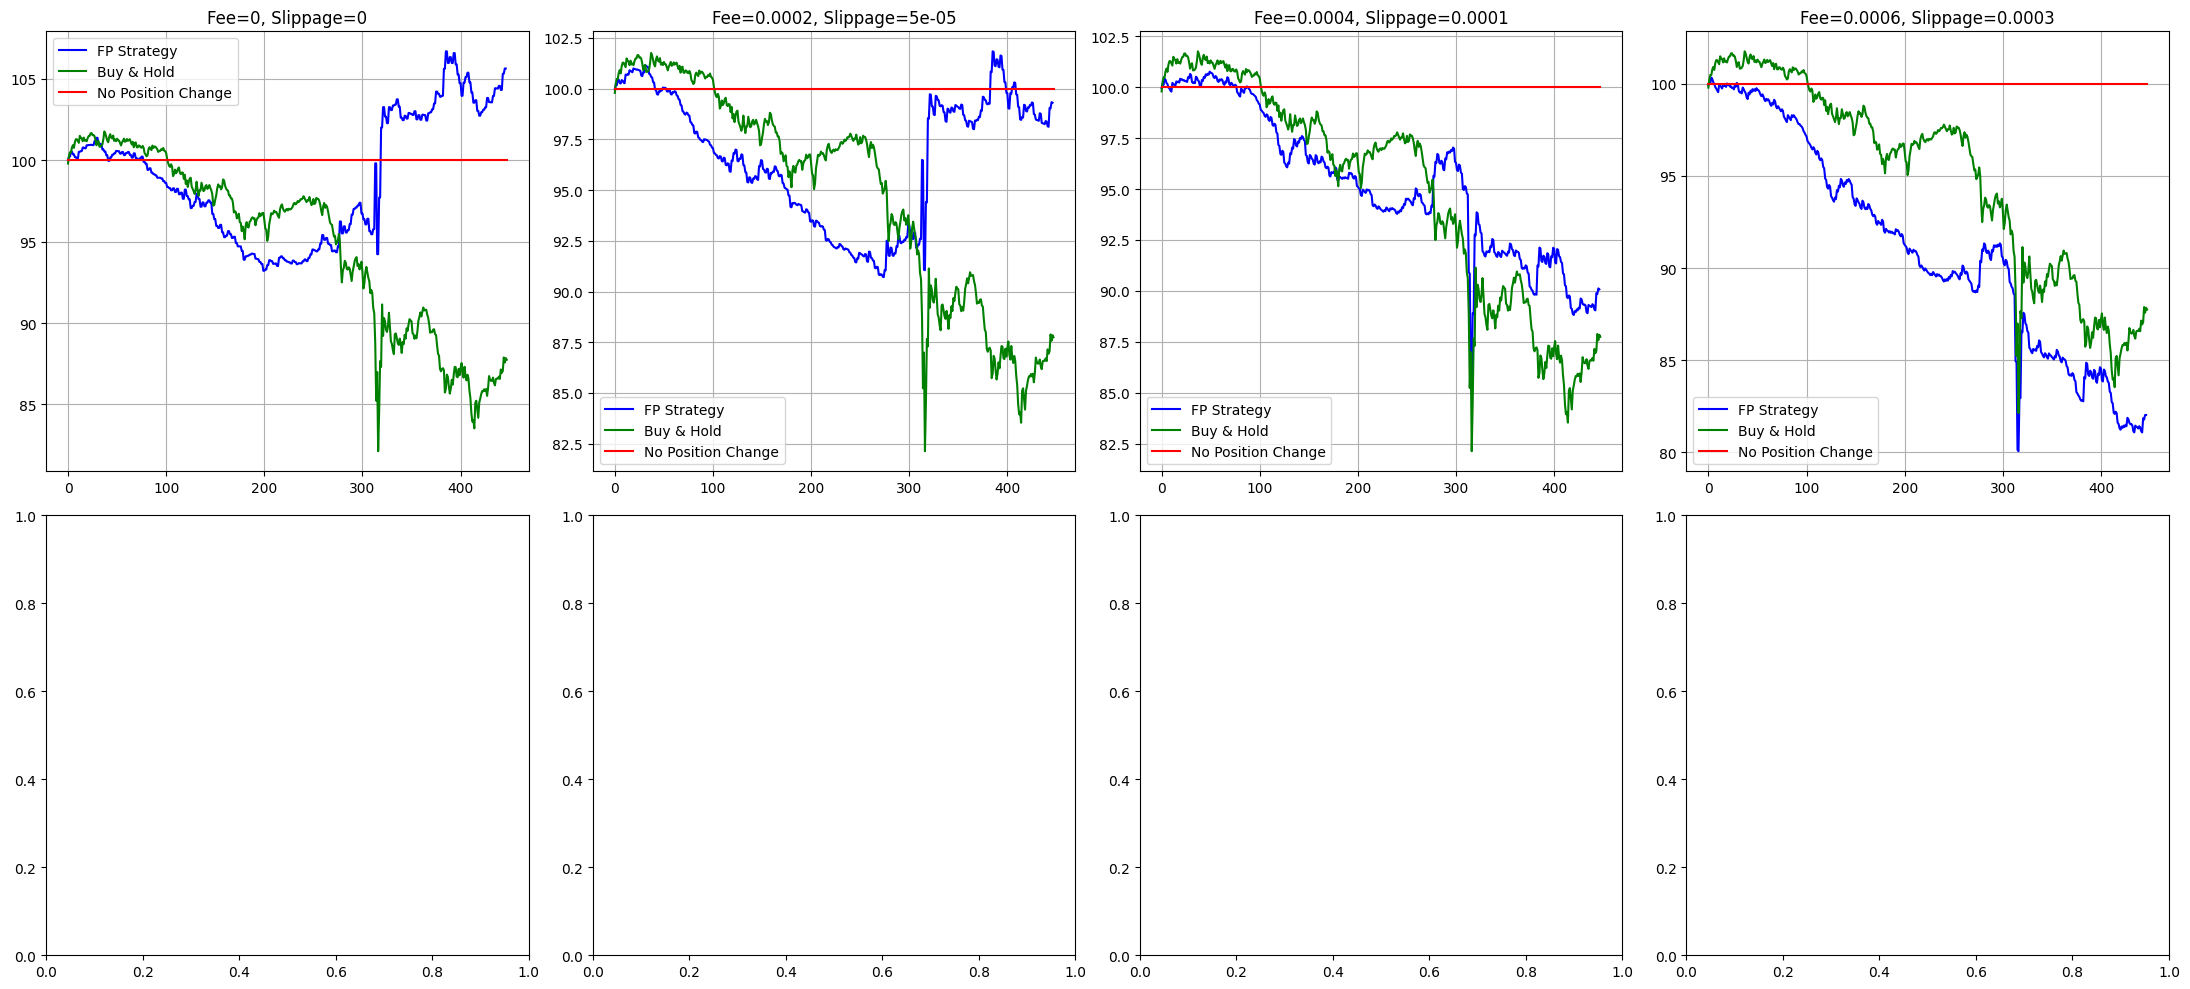


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000           105.63           5.63           87.74                 -12.26    100.0             0.0
0.0002   0.00005            99.31          -0.69           87.74                 -12.26    100.0             0.0
0.0004   0.00010            90.08          -9.92           87.74                 -12.26    100.0             0.0
0.0006   0.00030            82.03         -17.97           87.74                 -12.26    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

df = pd.read_csv("ETH_5min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']
bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]
df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope'] = df['bids_notional_0'] - df['bids_notional_5']

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

df_train['log_mid'] = np.log(df_train['midpoint'])
df_train['returns'] = df_train['log_mid'].diff().fillna(0)
df_cv['log_mid'] = np.log(df_cv['midpoint'])
df_cv['returns'] = df_cv['log_mid'].diff().fillna(0)
df_test['log_mid'] = np.log(df_test['midpoint'])
df_test['returns'] = df_test['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.where(signal > threshold, 1, np.where(signal < -threshold, -1, 0))
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, obi, timesteps, dt):
    a0, a1, a2 = mu_params
    b0, b1 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        mu = a0 + a1 * x[t-1] + a2 * obi[t-1]
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    obi = df_slice['obi'].values
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:3]
        sigma_params = params[3:]
        signal = simulate_fp(mu_params, sigma_params, x_init, obi, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0, 0, 0, 0.005, 0.005], sigma0=0.2, options={'seed':random_seed})
    return res[0][:3], res[0][3:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(0, 200), (200, 400), (400, 600), (600, 800), (800, 1000)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        if end > len(df_train):
            continue
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end]['obi'].values, end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    cv_obi = df_cv['obi'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, cv_obi[start:end], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_obi = df_test['obi'].values
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_obi[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        raise ValueError("No positions generated.")

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=42, Tue Jul 22 12:57:42 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -4.894983897072436e-02 1.0e+00 2.00e-01  2e-01  2e-01 0:00.1
    2     16 -3.552290459335072e-02 1.3e+00 2.03e-01  2e-01  2e-01 0:00.1
    3     24 -5.761652171783460e-02 1.5e+00 2.12e-01  2e-01  2e-01 0:00.2
   81    648 -8.908035578437623e-02 2.7e+01 7.25e-03  1e-03  6e-03 0:02.0
termination on tolflatfitness=1 (Tue Jul 22 12:57:44 2025)
final/bestever f-value = -8.908036e-02 -8.908036e-02 after 649/500 evaluations
incumbent solution: [ 0.53969945, -0.76235711, 0.10500557, -1.05157196, 0.00399708]
std deviation: [0.00291881, 0.00111565, 0.00178586, 0.00594, 0.00289382]
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=42, Tue Jul 22 12:57:44 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -3.605747241975177e-02 1.0e+00 1.78e-01  2e-01  2e-01 0:00.0
    2     16 -1.050

/tmp/ipython-input-7-1564720100.py:55: RuntimeWarning: overflow encountered in scalar multiply
  x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
/tmp/ipython-input-7-1564720100.py:55: RuntimeWarning: invalid value encountered in scalar add
  x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
/tmp/ipython-input-7-1564720100.py:53: RuntimeWarning: overflow encountered in scalar multiply
  mu = a0 + a1 * x[t-1] + a2 * obi[t-1]
/tmp/ipython-input-7-1564720100.py:54: RuntimeWarning: overflow encountered in scalar multiply
  sigma = np.abs(b0 + b1 * np.abs(x[t-1]))


   46    368 -4.214896014232656e-02 1.9e+01 1.81e-01  1e-01  2e-01 0:00.8
termination on tolflatfitness=1 (Tue Jul 22 12:58:00 2025)
final/bestever f-value = -4.214896e-02 -4.604630e-02 after 369/92 evaluations
incumbent solution: [-2.18457177, 3.59730805, 5.36567384, -2.78438605, -3.80496125]
std deviation: [0.14083593, 0.1567434, 0.22762503, 0.15296439, 0.13858823]
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=42, Tue Jul 22 12:58:00 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -1.000364613459021e-02 1.0e+00 1.79e-01  2e-01  2e-01 0:00.0
    2     16 -1.000364613459021e-02 1.3e+00 1.82e-01  2e-01  2e-01 0:00.0
    3     24 -1.000364613459021e-02 1.5e+00 1.88e-01  2e-01  2e-01 0:00.1


/tmp/ipython-input-7-1564720100.py:55: RuntimeWarning: overflow encountered in scalar add
  x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()


termination on tolfun=1e-11 (Tue Jul 22 12:58:00 2025)
termination on tolflatfitness=1 (Tue Jul 22 12:58:00 2025)
final/bestever f-value = -1.000365e-02 -1.000365e-02 after 25/5 evaluations
incumbent solution: [ 0.47046759, -0.1125464, 0.03856429, -0.21772953, -0.04419997]
std deviation: [0.20211133, 0.18070851, 0.16534958, 0.19023226, 0.17123874]
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=42, Tue Jul 22 12:58:00 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -9.222122584990167e-03 1.0e+00 1.74e-01  2e-01  2e-01 0:00.0
    2     16 -9.222122584990167e-03 1.3e+00 1.76e-01  2e-01  2e-01 0:00.0
    3     24 -9.345346386404775e-03 1.4e+00 1.96e-01  2e-01  2e-01 0:00.1
   32    256 -1.298142413695930e-02 5.6e+00 6.29e-02  3e-02  7e-02 0:00.5
termination on tolflatfitness=1 (Tue Jul 22 12:58:01 2025)
final/bestever f-value = -1.298142e-02 -1.597591e-02 after 257/30 evaluations
incumbent solution: [ 1.15216015, -0.34446713, -0.04745465,

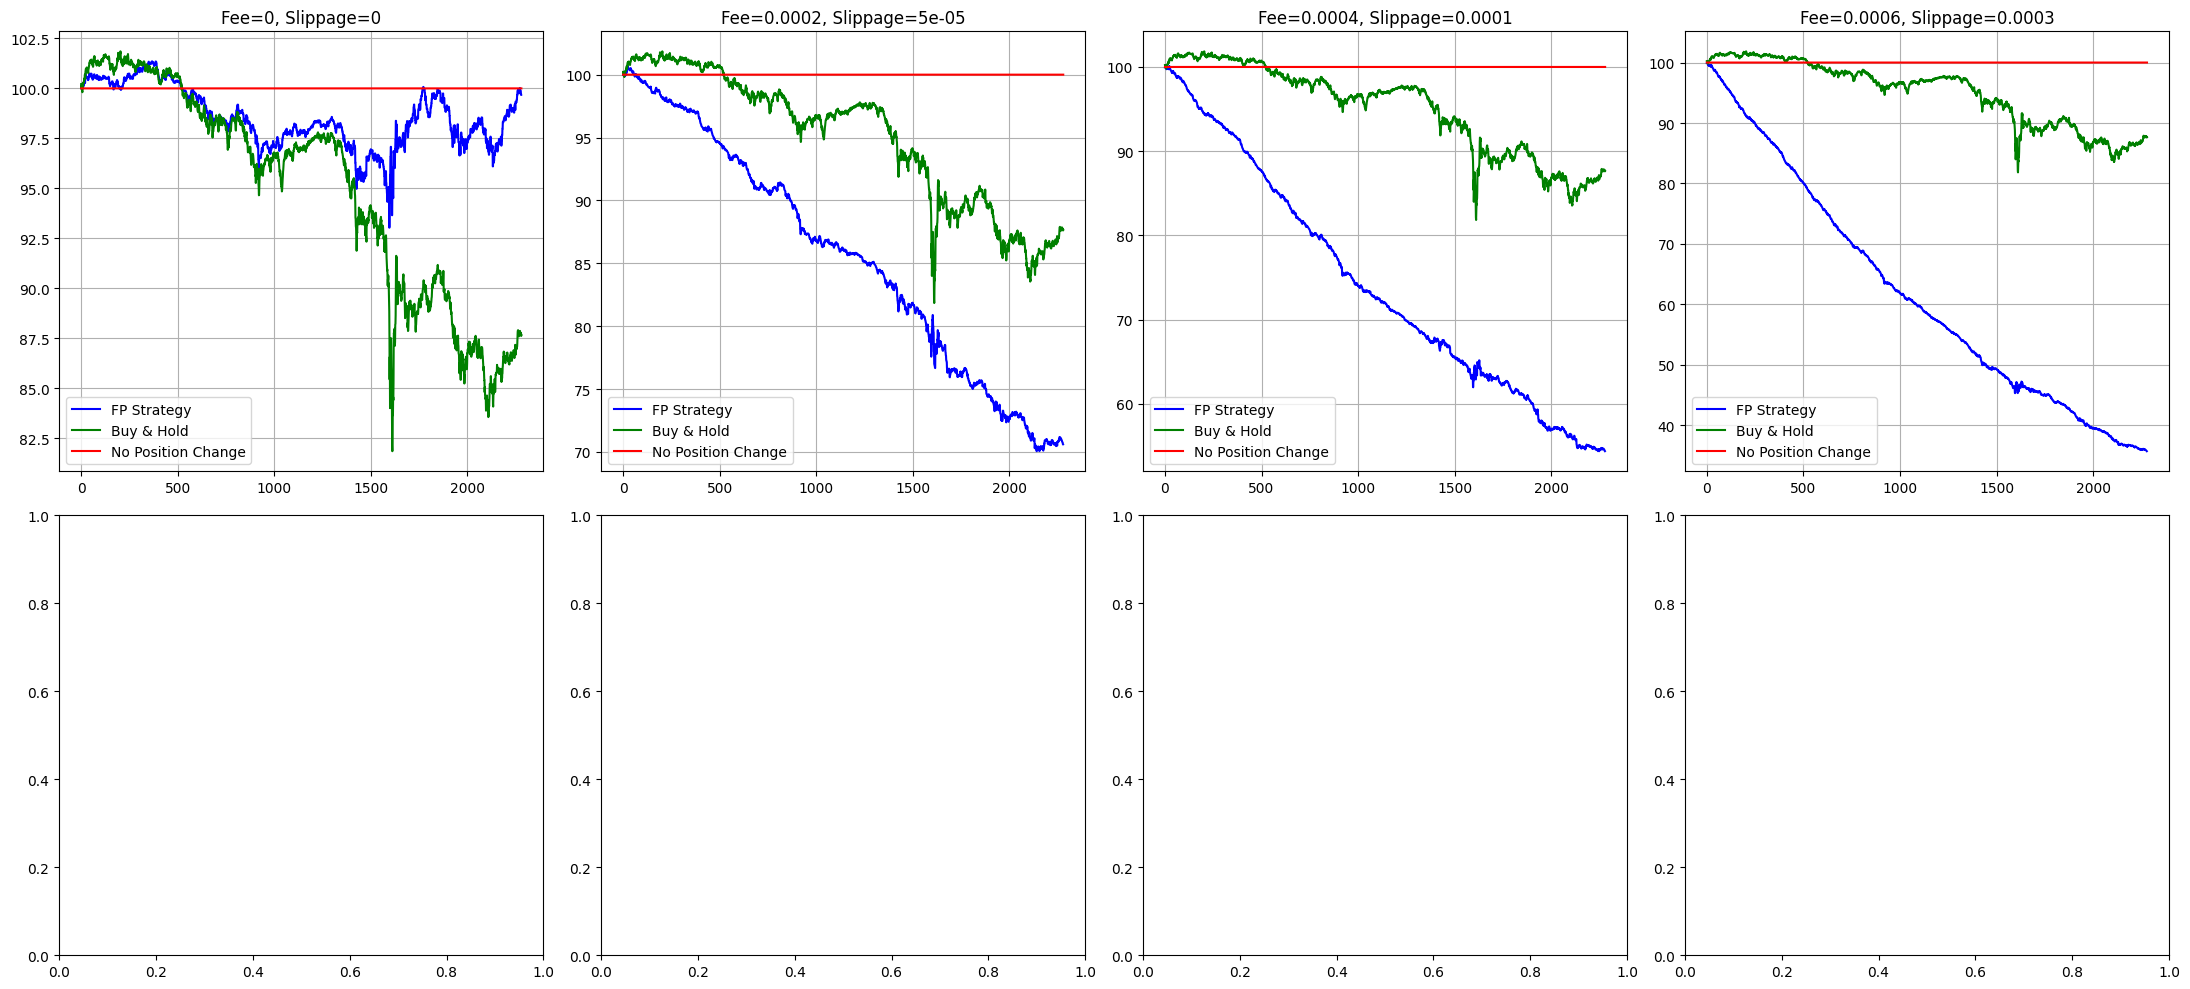


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000            99.68          -0.32           87.65                 -12.35    100.0             0.0
0.0002   0.00005            70.61         -29.39           87.65                 -12.35    100.0             0.0
0.0004   0.00010            54.40         -45.60           87.65                 -12.35    100.0             0.0
0.0006   0.00030            35.73         -64.27           87.65                 -12.35    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

df = pd.read_csv("ETH_1min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']
bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]
df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope'] = df['bids_notional_0'] - df['bids_notional_5']

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

df_train['log_mid'] = np.log(df_train['midpoint'])
df_train['returns'] = df_train['log_mid'].diff().fillna(0)
df_cv['log_mid'] = np.log(df_cv['midpoint'])
df_cv['returns'] = df_cv['log_mid'].diff().fillna(0)
df_test['log_mid'] = np.log(df_test['midpoint'])
df_test['returns'] = df_test['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.where(signal > threshold, 1, np.where(signal < -threshold, -1, 0))
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, obi, timesteps, dt):
    a0, a1, a2 = mu_params
    b0, b1 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        mu = a0 + a1 * x[t-1] + a2 * obi[t-1]
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    obi = df_slice['obi'].values
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:3]
        sigma_params = params[3:]
        signal = simulate_fp(mu_params, sigma_params, x_init, obi, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0, 0, 0, 0.005, 0.005], sigma0=0.2, options={'seed':random_seed})
    return res[0][:3], res[0][3:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(0, 500), (500, 1000), (1000, 1500), (1500, 2000), (2000, 2500)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        if end > len(df_train):
            continue
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end]['obi'].values, end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    cv_obi = df_cv['obi'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, cv_obi[start:end], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_obi = df_test['obi'].values
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_obi[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        raise ValueError("No positions generated.")

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=42, Tue Jul 22 12:58:43 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -4.624499488922940e-02 1.0e+00 2.00e-01  2e-01  2e-01 0:00.2


/tmp/ipython-input-8-2881762486.py:55: RuntimeWarning: overflow encountered in scalar add
  x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
/tmp/ipython-input-8-2881762486.py:55: RuntimeWarning: invalid value encountered in scalar add
  x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()


    2     16 -4.625334404713755e-02 1.3e+00 2.04e-01  2e-01  2e-01 0:00.3
    3     24 -4.429501649167111e-02 1.3e+00 1.76e-01  2e-01  2e-01 0:00.5
   23    184 -8.654376352954074e-02 3.4e+00 2.68e-01  1e-01  3e-01 0:03.5
   50    400 -1.189078819267451e-01 4.7e+00 5.60e-02  2e-02  4e-02 0:07.6
   81    648 -1.225266473595878e-01 1.3e+01 1.34e-02  3e-03  9e-03 0:12.7
  100    800 -1.226711261113627e-01 1.9e+01 4.58e-03  6e-04  3e-03 0:15.7
  138   1104 -1.228841363734423e-01 4.5e+01 1.30e-03  9e-05  7e-04 0:22.7
  143   1144 -1.228841363734423e-01 5.0e+01 1.04e-03  7e-05  4e-04 0:23.5
termination on tolflatfitness=1 (Tue Jul 22 12:59:06 2025)
final/bestever f-value = -1.228841e-01 -1.232340e-01 after 1145/748 evaluations
incumbent solution: [ 0.6580059, -1.01056512, 1.37594153, -0.1481399, 0.97114135]
std deviation: [2.18292031e-04, 6.57689410e-05, 4.36123386e-04, 8.41496186e-05, 1.31282446e-04]
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=42, Tue Jul 22 12:59:07 2025)
Itera

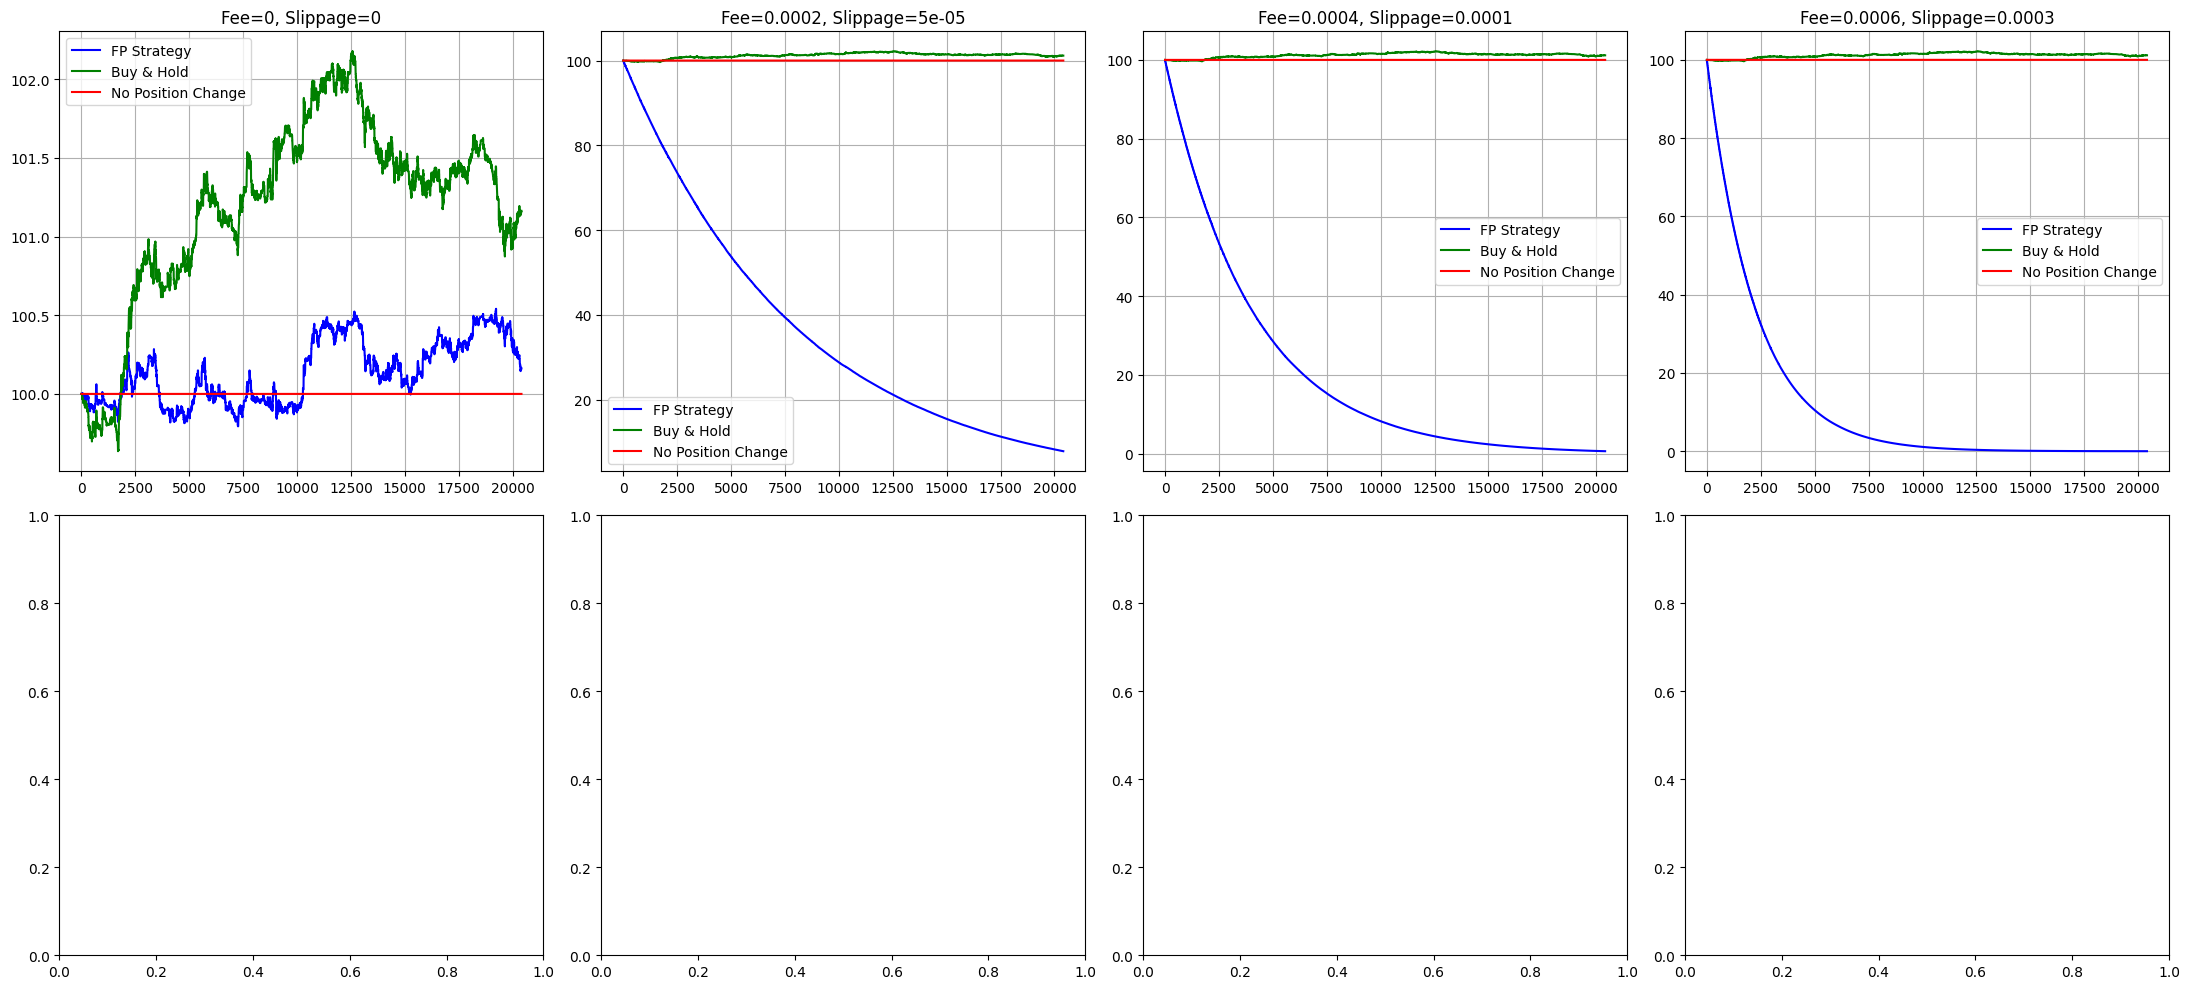


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000           100.16           0.16          101.16                   1.16    100.0             0.0
0.0002   0.00005             7.85         -92.15          101.16                   1.16    100.0             0.0
0.0004   0.00010             0.61         -99.39          101.16                   1.16    100.0             0.0
0.0006   0.00030             0.01         -99.99          101.16                   1.16    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

df = pd.read_csv("ETH_1sec.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']
bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]
df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope'] = df['bids_notional_0'] - df['bids_notional_5']

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

df_train['log_mid'] = np.log(df_train['midpoint'])
df_train['returns'] = df_train['log_mid'].diff().fillna(0)
df_cv['log_mid'] = np.log(df_cv['midpoint'])
df_cv['returns'] = df_cv['log_mid'].diff().fillna(0)
df_test['log_mid'] = np.log(df_test['midpoint'])
df_test['returns'] = df_test['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.where(signal > threshold, 1, np.where(signal < -threshold, -1, 0))
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, obi, timesteps, dt):
    a0, a1, a2 = mu_params
    b0, b1 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        mu = a0 + a1 * x[t-1] + a2 * obi[t-1]
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    obi = df_slice['obi'].values
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:3]
        sigma_params = params[3:]
        signal = simulate_fp(mu_params, sigma_params, x_init, obi, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0, 0, 0, 0.005, 0.005], sigma0=0.2, options={'seed':random_seed})
    return res[0][:3], res[0][3:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(0, 5000), (5000, 10000), (10000, 15000), (15000, 20000), (20000, 25000)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        if end > len(df_train):
            continue
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end]['obi'].values, end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    cv_obi = df_cv['obi'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, cv_obi[start:end], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_obi = df_test['obi'].values
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_obi[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        raise ValueError("No positions generated.")

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


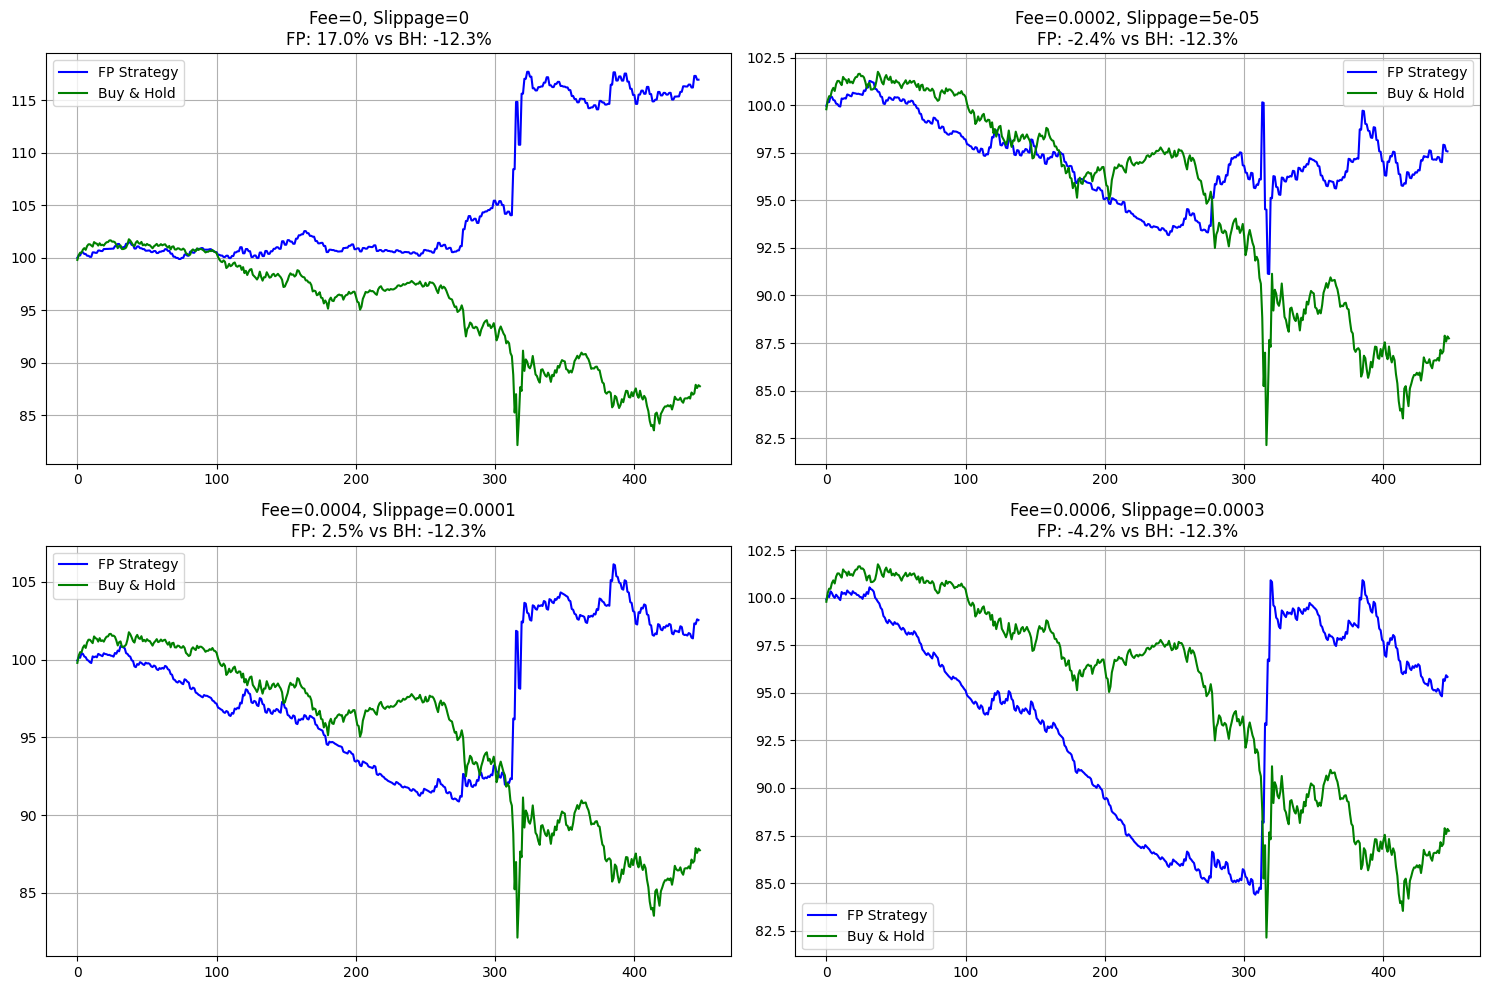


Performance Metrics Across Different Cost Scenarios:
 Fee  Slippage  FP Return (%)  FP Sharpe  FP Drawdown (%)  BH Return (%)  BH Sharpe  BH Drawdown (%)
0.00      0.00          16.98      22.80            -0.12         -12.26     -15.51           -17.87
0.00      0.00          -2.42      -3.55            -8.87         -12.26     -15.51           -17.87
0.00      0.00           2.54       3.63            -9.12         -12.26     -15.51           -17.87
0.00      0.00          -4.16      -6.11           -15.61         -12.26     -15.51           -17.87


In [ ]:
import pandas as pd
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict

# Configuration
class Config:
    RANDOM_SEED = 42
    TRAIN_RATIO = 0.6
    CV_RATIO = 0.2
    TEST_RATIO = 0.2
    INITIAL_CAPITAL = 100
    FEE_SLIPPAGE_COMBOS = [
        (0, 0),
        (0.0002, 0.00005),
        (0.0004, 0.0001),
        (0.0006, 0.0003)
    ]
    WINDOW_SIZE = 3
    N_MODEL_SEGMENTS = 5

np.random.seed(Config.RANDOM_SEED)

# Data Preparation
def prepare_data(filepath: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Load and preprocess the data"""
    df = pd.read_csv(filepath)

    # Calculate price levels
    for j in range(15):
        df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
        df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

    # Calculate features
    bid_cols = [f"bids_notional_{i}" for i in range(15)]
    ask_cols = [f"asks_notional_{i}" for i in range(15)]

    df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (
        df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
    df['dobi'] = df['obi'].diff().fillna(0)
    df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
    df['queue_slope'] = df['bids_notional_0'] - df['bids_notional_5']
    df['spread'] = df['ask_price_0'] - df['bid_price_0']

    # Log returns
    df['log_mid'] = np.log(df['midpoint'])
    df['returns'] = df['log_mid'].diff().fillna(0)

    # Train/Validation/Test split
    train_end = int(len(df) * Config.TRAIN_RATIO)
    cv_end = int(len(df) * (Config.TRAIN_RATIO + Config.CV_RATIO))

    df_train = df.iloc[:train_end].copy().reset_index(drop=True)
    df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
    df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

    # Feature scaling
    scaler = StandardScaler()
    scale_cols = ['obi', 'depth', 'queue_slope', 'spread']
    df_train[scale_cols] = scaler.fit_transform(df_train[scale_cols])
    df_cv[scale_cols] = scaler.transform(df_cv[scale_cols])
    df_test[scale_cols] = scaler.transform(df_test[scale_cols])

    return df_train, df_cv, df_test

# Trading Strategy Components
def trading_strategy(signal: np.ndarray, threshold: float) -> Tuple[np.ndarray, np.ndarray]:
    """Generate positions from trading signals"""
    positions = np.zeros_like(signal)
    positions[signal > threshold] = 1
    positions[signal < -threshold] = -1
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(
    positions: np.ndarray,
    trades: np.ndarray,
    returns: np.ndarray,
    fee: float,
    slip: float,
    trade_sizes: np.ndarray = None
) -> np.ndarray:
    """Calculate PnL with realistic trading costs"""
    raw_pnl = positions[:-1] * returns[1:len(positions)]

    # Dynamic slippage based on trade size and liquidity
    if trade_sizes is None:
        costs = np.abs(trades[1:len(positions)]) * (fee + slip)
    else:
        liquidity_impact = 0.0001 * (trade_sizes / 1e6)  # Assume liquidity in millions
        costs = np.abs(trades[1:len(positions)]) * (fee + slip + liquidity_impact)

    return raw_pnl - costs

# Signal Generation Model
def simulate_fp(
    mu_params: List[float],
    sigma_params: List[float],
    x0: float,
    obi: np.ndarray,
    timesteps: int,
    dt: float = 1.0
) -> np.ndarray:
    """Fokker-Planck inspired signal generation"""
    a0, a1, a2 = mu_params
    b0, b1 = sigma_params

    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(Config.RANDOM_SEED)

    for t in range(1, timesteps):
        mu = a0 + a1 * x[t-1] + a2 * obi[t-1]
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()

    return x

# Optimization
def optimize_threshold(
    signal: np.ndarray,
    returns: np.ndarray,
    fee: float,
    slip: float
) -> float:
    """Find optimal trading threshold"""
    thresholds = np.linspace(0.001, 0.01, 20)
    best_pnl = -np.inf
    best_thresh = 0.005

    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))

        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t

    return best_thresh

def train_fp_model(
    df_slice: pd.DataFrame,
    fee: float,
    slip: float
) -> Tuple[List[float], List[float]]:
    """Train model using Bayesian optimization"""
    returns = df_slice['returns'].values
    obi = df_slice['obi'].values
    x_init = 0.0

    def objective(params):
        mu_params = params[:3]
        sigma_params = params[3:]
        signal = simulate_fp(mu_params, sigma_params, x_init, obi, len(returns))
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))

    space = [
        Real(-1, 1, name='a0'),
        Real(-1, 1, name='a1'),
        Real(-1, 1, name='a2'),
        Real(0.0001, 0.1, name='b0'),
        Real(0.0001, 0.1, name='b1')
    ]

    res = gp_minimize(objective, space, n_calls=50, random_state=Config.RANDOM_SEED)
    return res.x[:3], res.x[3:]

# Backtest Framework
def run_backtest(
    df_train: pd.DataFrame,
    df_cv: pd.DataFrame,
    df_test: pd.DataFrame,
    fee: float,
    slip: float
) -> Dict:
    """Complete backtest pipeline for one fee/slippage combo"""
    # 1. Train multiple models on different segments
    segment_size = len(df_train) // Config.N_MODEL_SEGMENTS
    segment_models = []
    segment_thresholds = []

    for i in range(Config.N_MODEL_SEGMENTS):
        start = i * segment_size
        end = (i + 1) * segment_size
        if end > len(df_train):
            continue

        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0,
                           df_train.iloc[start:end]['obi'].values,
                           end - start)
        threshold = optimize_threshold(signal,
                                     df_train.iloc[start:end]['returns'].values,
                                     fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    # 2. Model selection on CV data
    selected_models = []
    cv_returns = df_cv['returns'].values
    cv_obi = df_cv['obi'].values

    for start in range(0, len(cv_returns) - Config.WINDOW_SIZE, Config.WINDOW_SIZE):
        end = start + Config.WINDOW_SIZE
        best_pnl = -np.inf
        best_index = 0

        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0,
                               cv_obi[start:end],
                               Config.WINDOW_SIZE)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades,
                                            cv_returns[start:end],
                                            fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i

        selected_models.append(best_index)

    # 3. Test on out-of-sample data
    test_returns = df_test['returns'].values
    test_obi = df_test['obi'].values
    test_positions = []
    test_trades = []

    for i, start in enumerate(range(0, len(test_returns) - Config.WINDOW_SIZE + 1, Config.WINDOW_SIZE)):
        end = start + Config.WINDOW_SIZE
        model_idx = selected_models[min(i, len(selected_models) - 1)]
        mu_p, sigma_p = segment_models[model_idx]
        threshold = segment_thresholds[model_idx]

        signal = simulate_fp(mu_p, sigma_p, 0.0,
                           test_obi[start:end],
                           min(Config.WINDOW_SIZE, len(test_returns) - start))
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    # Combine results
    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    # Calculate PnLs
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = Config.INITIAL_CAPITAL * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = Config.INITIAL_CAPITAL * np.exp(np.cumsum(bh_returns))

    # Calculate metrics
    def calculate_metrics(returns):
        total_return = (np.exp(np.sum(returns)) - 1) * 100
        sharpe = np.mean(returns) / np.std(returns) * np.sqrt(365*24*12)  # 5min periods
        max_drawdown = (np.exp(np.min(returns.cumsum())) - 1) * 100
        return total_return, sharpe, max_drawdown

    fp_metrics = calculate_metrics(fp_net_returns)
    bh_metrics = calculate_metrics(bh_returns)

    return {
        'fee': fee,
        'slippage': slip,
        'fp_pnl': fp_pnl,
        'bh_pnl': bh_pnl,
        'fp_return_pct': fp_metrics[0],
        'fp_sharpe': fp_metrics[1],
        'fp_drawdown_pct': fp_metrics[2],
        'bh_return_pct': bh_metrics[0],
        'bh_sharpe': bh_metrics[1],
        'bh_drawdown_pct': bh_metrics[2]
    }

# Main Execution
if __name__ == "__main__":
    # Load and prepare data
    df_train, df_cv, df_test = prepare_data("ETH_5min.csv")

    # Run backtests for all fee/slippage combinations
    results = []
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for idx, (fee, slip) in enumerate(Config.FEE_SLIPPAGE_COMBOS):
        result = run_backtest(df_train, df_cv, df_test, fee, slip)
        results.append(result)

        # Plotting
        ax = axes[idx]
        ax.plot(result['fp_pnl'], label='FP Strategy', color='blue')
        ax.plot(result['bh_pnl'], label='Buy & Hold', color='green')
        ax.set_title(f"Fee={fee}, Slippage={slip}\n"
                    f"FP: {result['fp_return_pct']:.1f}% vs BH: {result['bh_return_pct']:.1f}%")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Results table
    results_df = pd.DataFrame([{
        'Fee': r['fee'],
        'Slippage': r['slippage'],
        'FP Return (%)': r['fp_return_pct'],
        'FP Sharpe': r['fp_sharpe'],
        'FP Drawdown (%)': r['fp_drawdown_pct'],
        'BH Return (%)': r['bh_return_pct'],
        'BH Sharpe': r['bh_sharpe'],
        'BH Drawdown (%)': r['bh_drawdown_pct']
    } for r in results])

    print("\nPerformance Metrics Across Different Cost Scenarios:")
    print(results_df.to_string(index=False, float_format="%.2f"))

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=42, Wed Jul 23 09:39:19 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -1.606676083059089e-02 1.0e+00 1.87e-01  2e-01  2e-01 0:00.2
    2     20 -2.142526964787894e-02 1.1e+00 1.78e-01  2e-01  2e-01 0:00.4
    3     30 -2.142526964787894e-02 1.2e+00 1.67e-01  2e-01  2e-01 0:00.7
    5     50 -1.606676083059089e-02 1.4e+00 1.68e-01  2e-01  2e-01 0:01.0
termination on tolflatfitness=1 (Wed Jul 23 09:39:20 2025)
final/bestever f-value = -1.606676e-02 -2.142527e-02 after 51/16 evaluations
incumbent solution: [ 0.16910801  0.08138616  0.09185534 -0.05075645  0.31538146 -0.05509622
  0.00066397  0.4387675  ...]
std deviations: [0.16580245 0.154616   0.15855012 0.15352079 0.16454697 0.16337627
 0.16196324 0.17747393 ...]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=42, Wed Jul 23 09:39:20 2025)


KeyError: 0

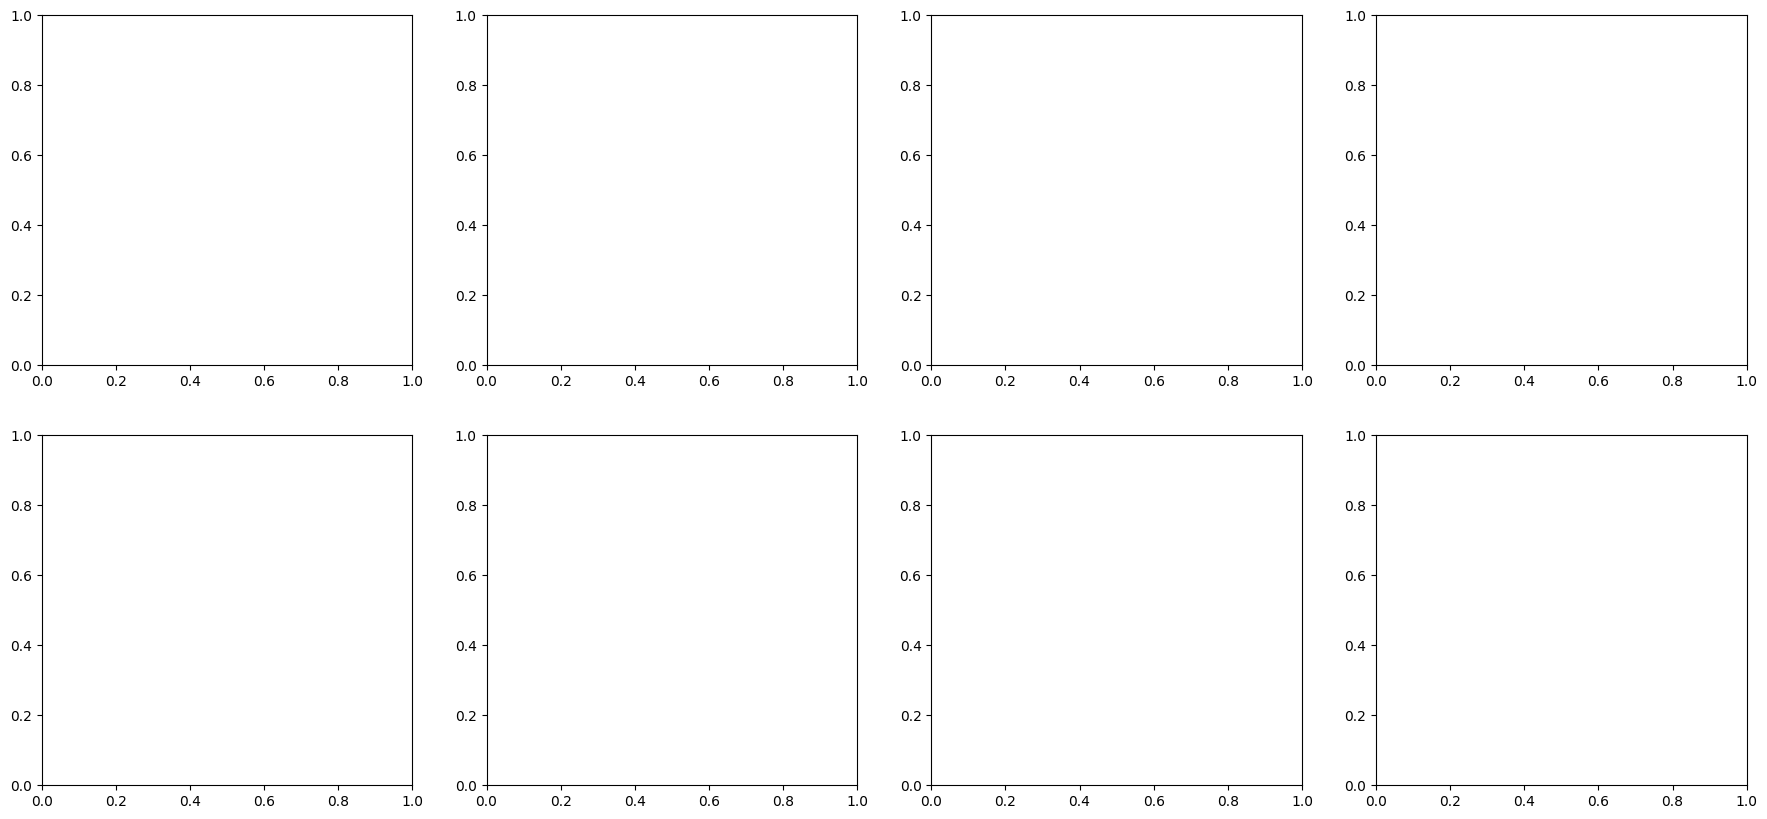

In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

df = pd.read_csv("ETH_5min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']
bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]
df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope'] = df['bids_notional_0'] - df['bids_notional_5']
df['spread'] = df['ask_price_0'] - df['bid_price_0']

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

for d in [df_train, df_cv, df_test]:
    d['log_mid'] = np.log(d['midpoint'])
    d['returns'] = d['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.where(signal > threshold, 1, np.where(signal < -threshold, -1, 0))
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, features, timesteps, dt):
    a0, a1, a2, a3, a4, a5, a6 = mu_params
    b0, b1 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        obi_t = features['obi'][t-1]
        dobi_t = features['dobi'][t-1]
        depth_t = features['depth'][t-1]
        slope_t = features['queue_slope'][t-1]
        spread_t = features['spread'][t-1]
        mu = (a0 + a1 * x[t-1] + a2 * obi_t + a3 * dobi_t + a4 * depth_t + a5 * slope_t + a6 * spread_t)
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    features = df_slice[['obi', 'dobi', 'depth', 'queue_slope', 'spread']]
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:7]
        sigma_params = params[7:]
        signal = simulate_fp(mu_params, sigma_params, x_init, features, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0]*7 + [0.005, 0.005], sigma0=0.2, options={'seed':random_seed})
    return res[0][:7], res[0][7:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(0, 200), (200, 400), (400, 600), (600, 800), (800, 1000)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        if end > len(df_train):
            continue
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end][['obi', 'dobi', 'depth', 'queue_slope', 'spread']], end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, df_cv.iloc[start:end][['obi', 'dobi', 'depth', 'queue_slope', 'spread']], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_features = df_test[['obi', 'dobi', 'depth', 'queue_slope', 'spread']]
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_features.iloc[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        raise ValueError("No positions generated.")

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


In [ ]:
for i in df.columns:
  print (i)

Unnamed: 0
system_time
midpoint
spread
buys
sells
bids_distance_0
bids_distance_1
bids_distance_2
bids_distance_3
bids_distance_4
bids_distance_5
bids_distance_6
bids_distance_7
bids_distance_8
bids_distance_9
bids_distance_10
bids_distance_11
bids_distance_12
bids_distance_13
bids_distance_14
bids_notional_0
bids_notional_1
bids_notional_2
bids_notional_3
bids_notional_4
bids_notional_5
bids_notional_6
bids_notional_7
bids_notional_8
bids_notional_9
bids_notional_10
bids_notional_11
bids_notional_12
bids_notional_13
bids_notional_14
bids_cancel_notional_0
bids_cancel_notional_1
bids_cancel_notional_2
bids_cancel_notional_3
bids_cancel_notional_4
bids_cancel_notional_5
bids_cancel_notional_6
bids_cancel_notional_7
bids_cancel_notional_8
bids_cancel_notional_9
bids_cancel_notional_10
bids_cancel_notional_11
bids_cancel_notional_12
bids_cancel_notional_13
bids_cancel_notional_14
bids_limit_notional_0
bids_limit_notional_1
bids_limit_notional_2
bids_limit_notional_3
bids_limit_notional_4


/tmp/ipython-input-8-1345527685.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)


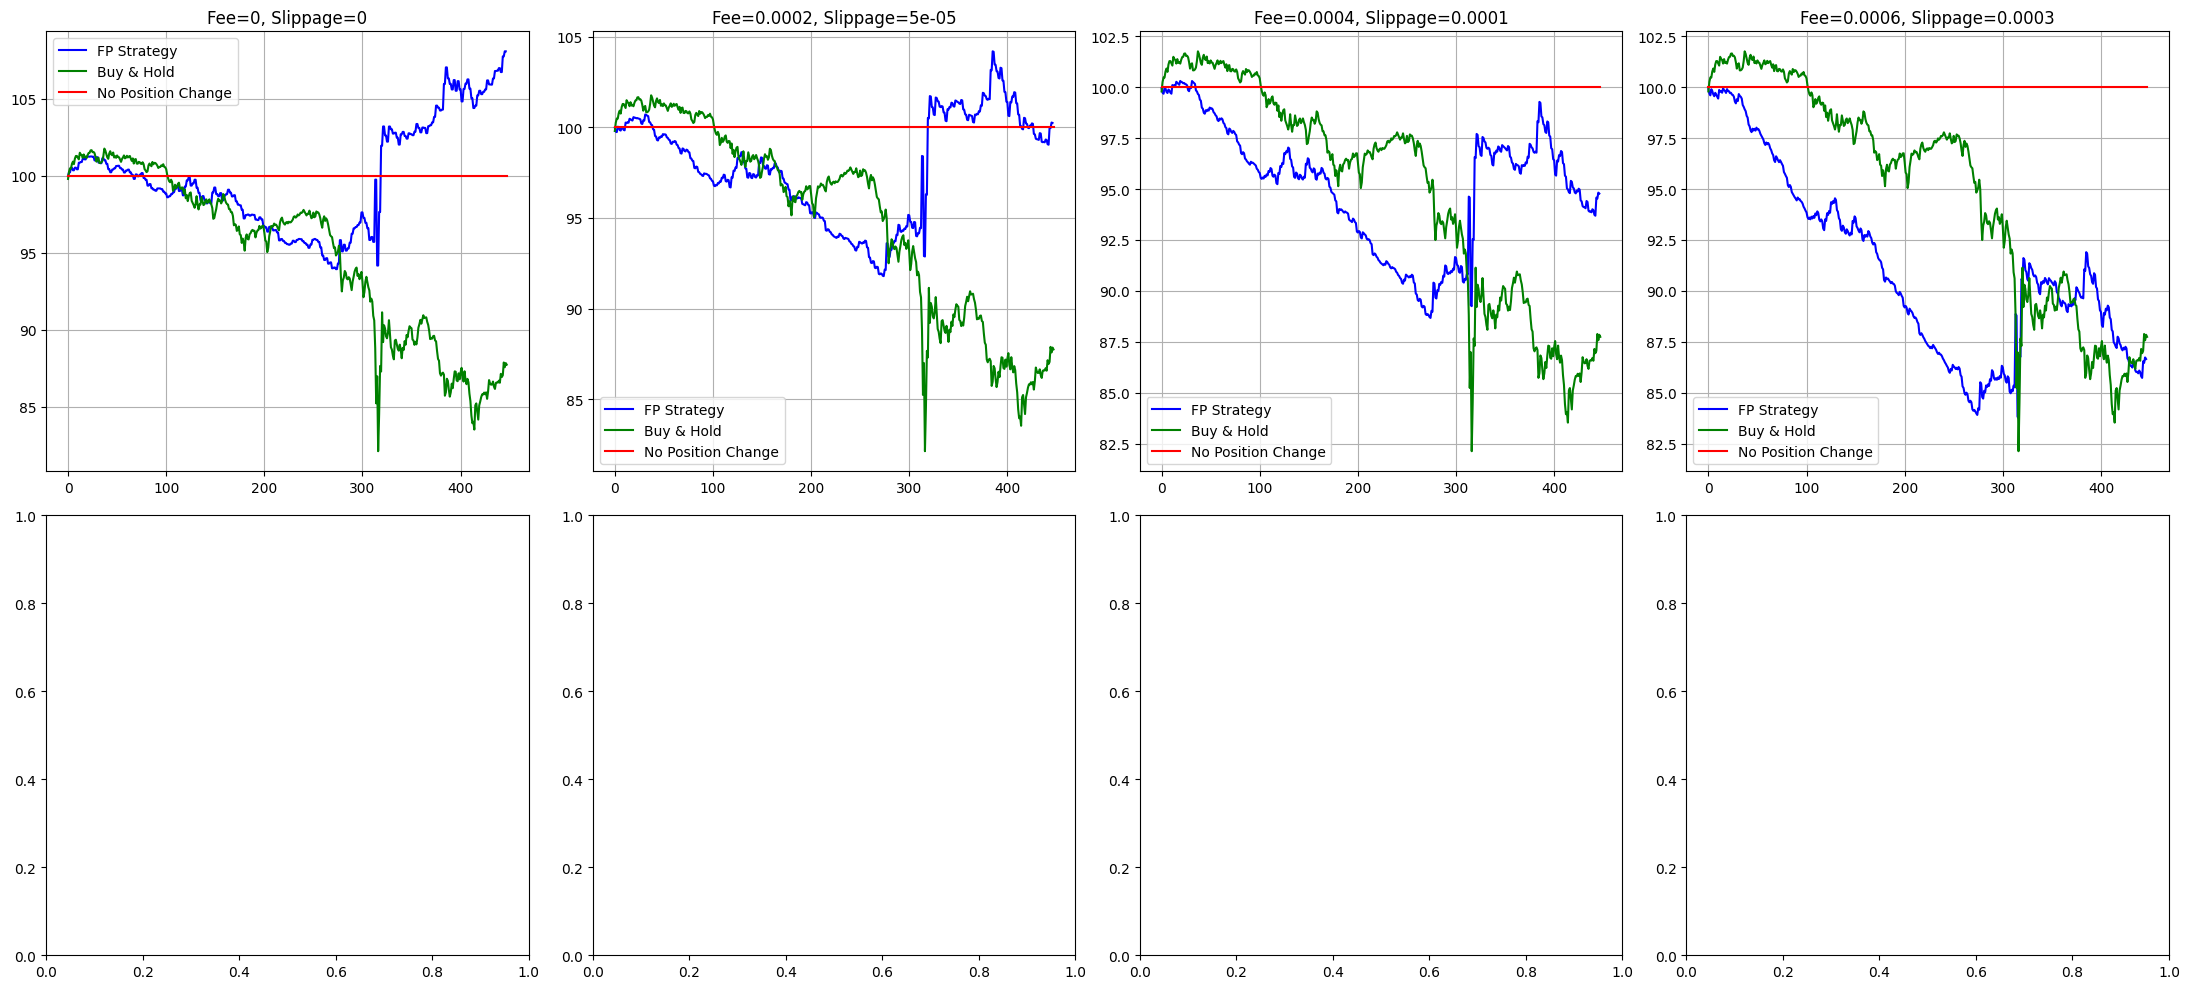


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000           108.07           8.07           87.74                 -12.26    100.0             0.0
0.0002   0.00005           100.24           0.24           87.74                 -12.26    100.0             0.0
0.0004   0.00010            94.78          -5.22           87.74                 -12.26    100.0             0.0
0.0006   0.00030            86.65         -13.35           87.74                 -12.26    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

df = pd.read_csv("ETH_5min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]
df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope'] = df['bids_notional_0'] - df['bids_notional_5']
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

for d in [df_train, df_cv, df_test]:
    d['log_mid'] = np.log(d['midpoint'])
    d['returns'] = d['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.where(signal > threshold, 1, np.where(signal < -threshold, -1, 0))
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, features, timesteps, dt):
    a0, a1, a2, a3, a4, a5, a6 = mu_params
    b0, b1 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        obi_t = features['obi'].iloc[t-1]
        dobi_t = features['dobi'].iloc[t-1]
        depth_t = features['depth'].iloc[t-1]
        slope_t = features['queue_slope'].iloc[t-1]
        spread_t = features['spread'].iloc[t-1]
        mu = (a0 + a1 * x[t-1] + a2 * obi_t + a3 * dobi_t + a4 * depth_t + a5 * slope_t + a6 * spread_t)
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    features = df_slice[['obi', 'dobi', 'depth', 'queue_slope', 'spread']]
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:7]
        sigma_params = params[7:]
        signal = simulate_fp(mu_params, sigma_params, x_init, features, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0]*7 + [0.005, 0.005], sigma0=0.2, options={'seed':random_seed, 'verb_disp':0})
    return res[0][:7], res[0][7:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(i, i+200) for i in range(0, len(df_train)-200, 200)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end][['obi', 'dobi', 'depth', 'queue_slope', 'spread']], end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, df_cv.iloc[start:end][['obi', 'dobi', 'depth', 'queue_slope', 'spread']], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_features = df_test[['obi', 'dobi', 'depth', 'queue_slope', 'spread']]
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_features.iloc[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        continue

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


/tmp/ipython-input-12-2841790008.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
/tmp/ipython-input-12-2841790008.py:58: RuntimeWarning: overflow encountered in scalar multiply
  mu = (a0 + a1 * x[t-1] + a2 * obi_t + a3 * dobi_t + a4 * depth_t + a5 * slope_t + a6 * spread_t)
/tmp/ipython-input-12-2841790008.py:59: RuntimeWarning: overflow encountered in scalar multiply
  sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
/tmp/ipython-input-12-2841790008.py:60: RuntimeWarning: invalid value encountered in scalar add
  x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
/tmp/ipython-input-12-2841790008.py:60: RuntimeWarning: overflow encountered in scalar add
  x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
/tmp/ipython-input-12-2841790008.py:60: RuntimeWarning: overflow encountered in scalar multiply
  x[t] = x[t-1] + mu * 

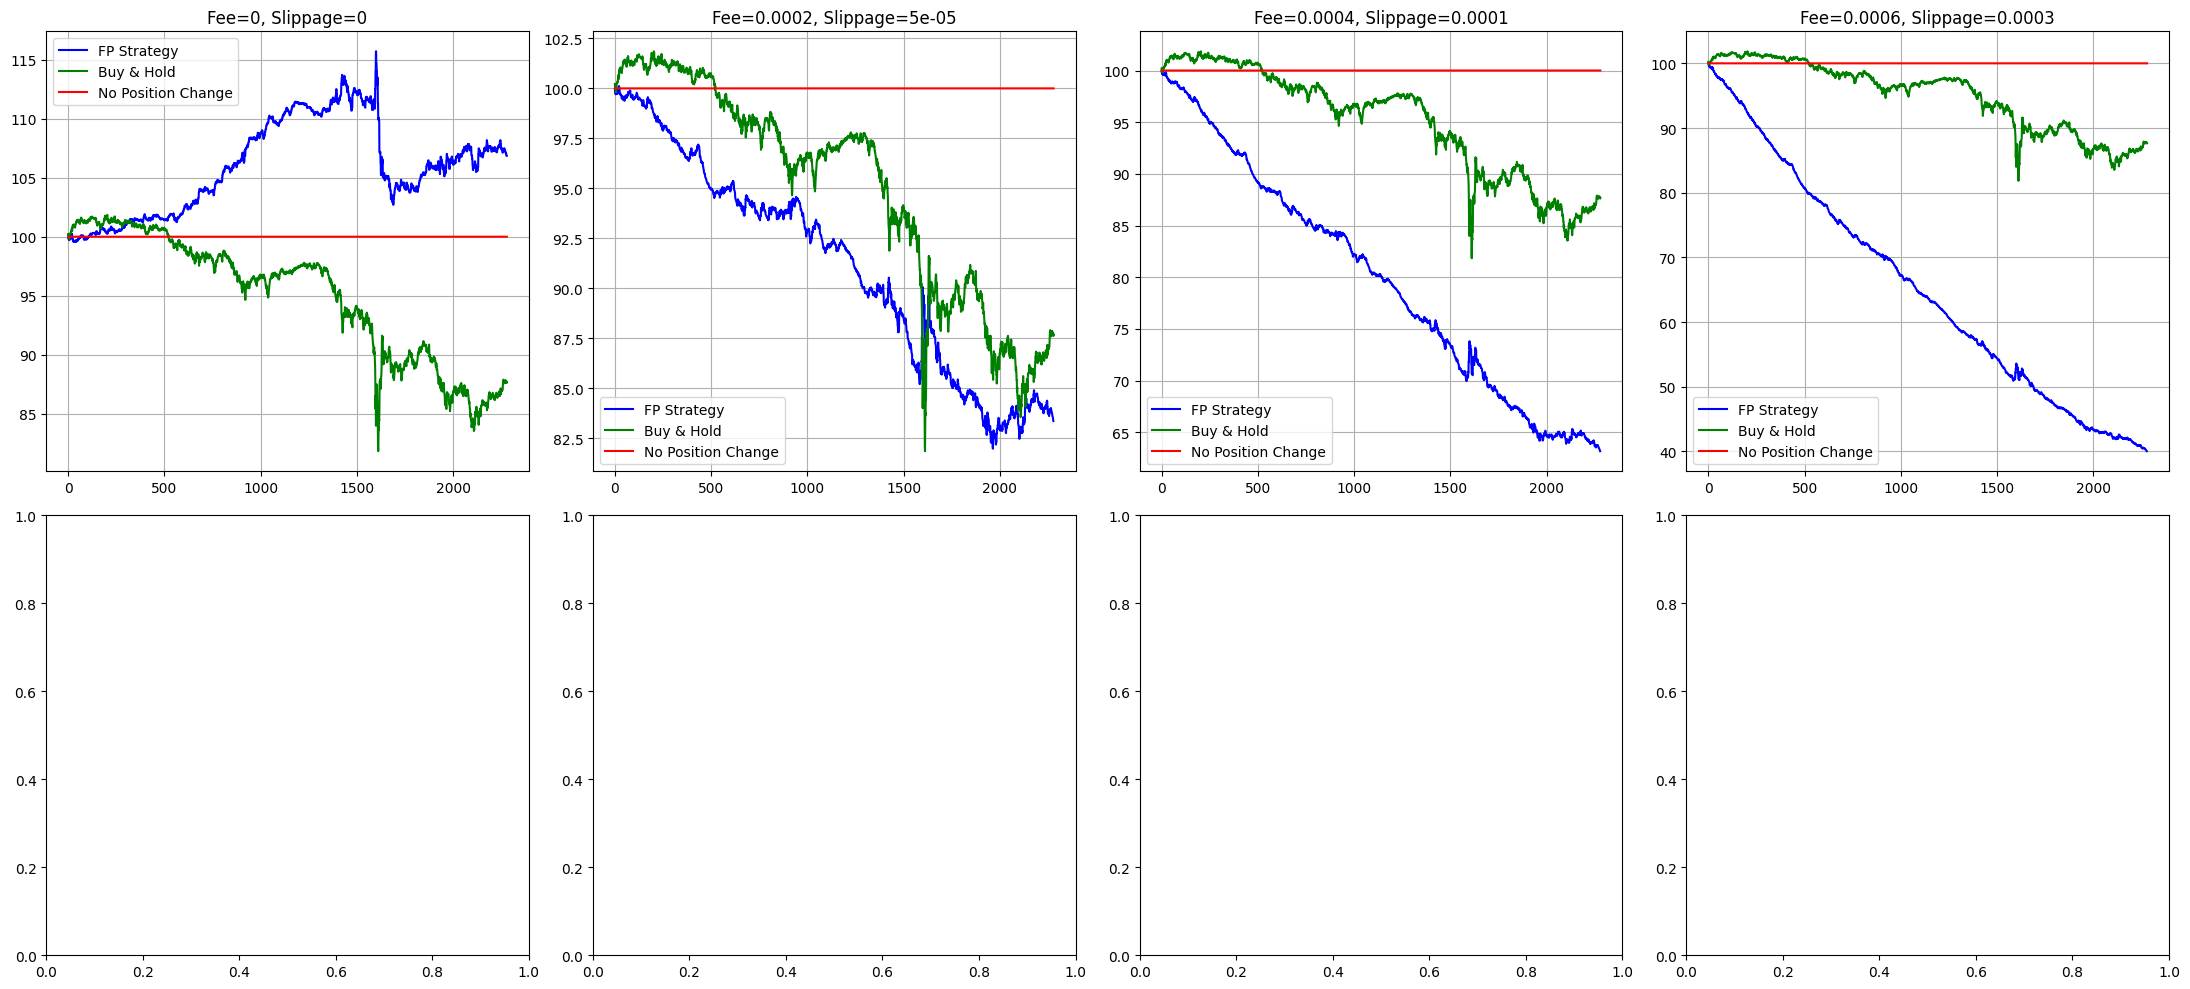


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000           106.84           6.84           87.65                 -12.35    100.0             0.0
0.0002   0.00005            83.35         -16.65           87.65                 -12.35    100.0             0.0
0.0004   0.00010            63.18         -36.82           87.65                 -12.35    100.0             0.0
0.0006   0.00030            40.04         -59.96           87.65                 -12.35    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

df = pd.read_csv("ETH_1min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]
df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope'] = df['bids_notional_0'] - df['bids_notional_5']
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

for d in [df_train, df_cv, df_test]:
    d['log_mid'] = np.log(d['midpoint'])
    d['returns'] = d['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.where(signal > threshold, 1, np.where(signal < -threshold, -1, 0))
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, features, timesteps, dt):
    a0, a1, a2, a3, a4, a5, a6 = mu_params
    b0, b1 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        obi_t = features['obi'].iloc[t-1]
        dobi_t = features['dobi'].iloc[t-1]
        depth_t = features['depth'].iloc[t-1]
        slope_t = features['queue_slope'].iloc[t-1]
        spread_t = features['spread'].iloc[t-1]
        mu = (a0 + a1 * x[t-1] + a2 * obi_t + a3 * dobi_t + a4 * depth_t + a5 * slope_t + a6 * spread_t)
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    features = df_slice[['obi', 'dobi', 'depth', 'queue_slope', 'spread']]
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:7]
        sigma_params = params[7:]
        signal = simulate_fp(mu_params, sigma_params, x_init, features, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0]*7 + [0.005, 0.005], sigma0=0.2, options={'seed':random_seed, 'verb_disp':0})
    return res[0][:7], res[0][7:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(i, i+500) for i in range(0, len(df_train)-500, 500)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end][['obi', 'dobi', 'depth', 'queue_slope', 'spread']], end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, df_cv.iloc[start:end][['obi', 'dobi', 'depth', 'queue_slope', 'spread']], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_features = df_test[['obi', 'dobi', 'depth', 'queue_slope', 'spread']]
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_features.iloc[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        continue

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


/tmp/ipython-input-2-1122171351.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)


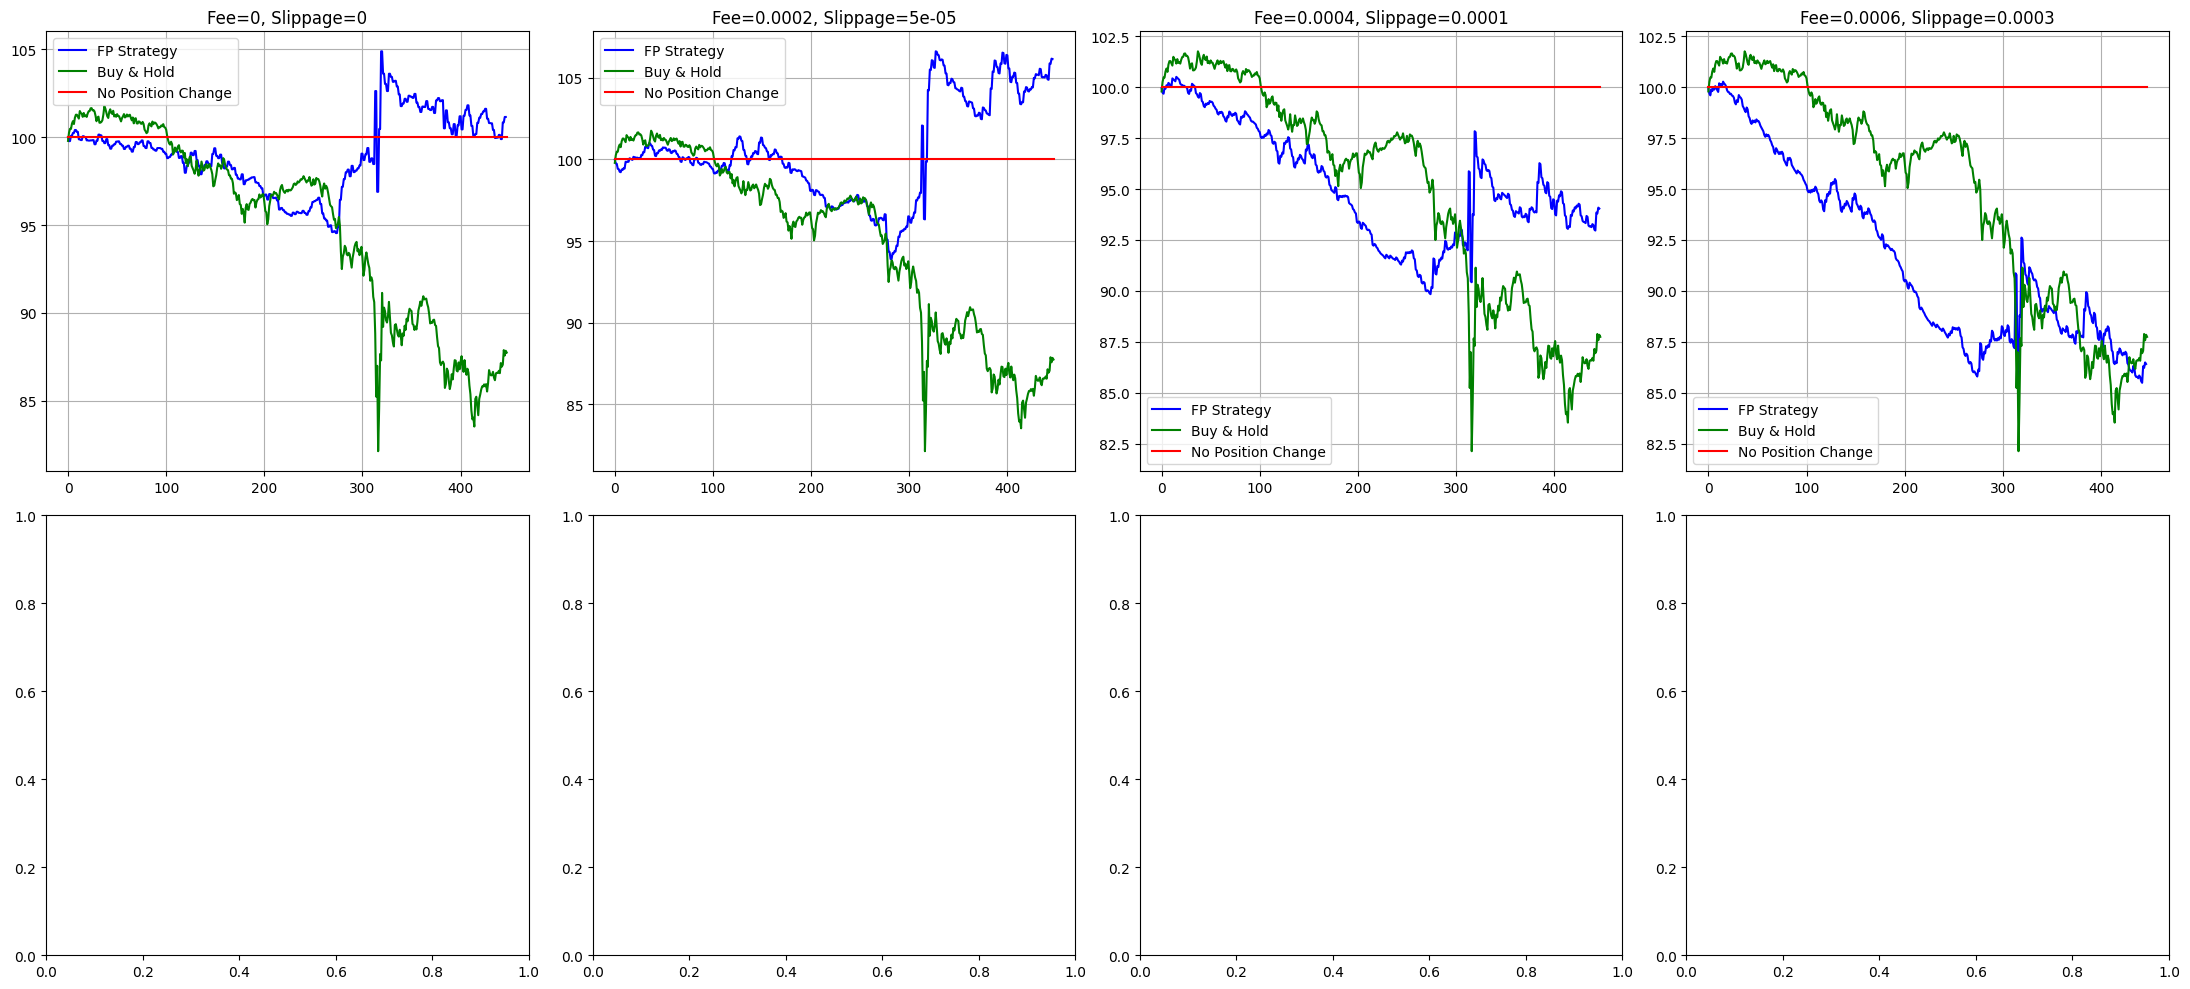


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000           101.16           1.16           87.74                 -12.26    100.0             0.0
0.0002   0.00005           106.15           6.15           87.74                 -12.26    100.0             0.0
0.0004   0.00010            94.04          -5.96           87.74                 -12.26    100.0             0.0
0.0006   0.00030            86.41         -13.59           87.74                 -12.26    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

df = pd.read_csv("ETH_5min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]

df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope_bid'] = df['bids_notional_0'] - df['bids_notional_5']
df['queue_slope_ask'] = df['asks_notional_0'] - df['asks_notional_5']
df['net_queue_slope'] = df['queue_slope_bid'] - df['queue_slope_ask']
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
df['depth_variance'] = df[bid_cols + ask_cols].std(axis=1)
df['abs_dobi'] = df['dobi'].abs()

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

for d in [df_train, df_cv, df_test]:
    d['log_mid'] = np.log(d['midpoint'])
    d['returns'] = d['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.where(signal > threshold, 1, np.where(signal < -threshold, -1, 0))
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, features, timesteps, dt):
    a0, a1, a2, a3, a4, a5, a6, a7, a8, a9 = mu_params
    b0, b1, b2 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        obi = features['obi'].iloc[t-1]
        dobi = features['dobi'].iloc[t-1]
        depth = features['depth'].iloc[t-1]
        net_slope = features['net_queue_slope'].iloc[t-1]
        spread = features['spread'].iloc[t-1]
        depth_var = features['depth_variance'].iloc[t-1]
        abs_dobi = features['abs_dobi'].iloc[t-1]
        mu = (a0 + a1 * x[t-1] + a2 * obi + a3 * dobi + a4 * depth + a5 * net_slope + a6 * spread + a7 * depth_var + a8 * abs_dobi + a9 * np.sign(x[t-1]))
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]) + b2 * spread)
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    features = df_slice[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:10]
        sigma_params = params[10:]
        signal = simulate_fp(mu_params, sigma_params, x_init, features, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0]*10 + [0.005, 0.005, 0.005], sigma0=0.2, options={'seed':random_seed, 'verb_disp':0})
    return res[0][:10], res[0][10:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(i, i+200) for i in range(0, len(df_train)-200, 200)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, df_cv.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_features = df_test[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_features.iloc[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        continue

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


/tmp/ipython-input-3-2079363087.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)


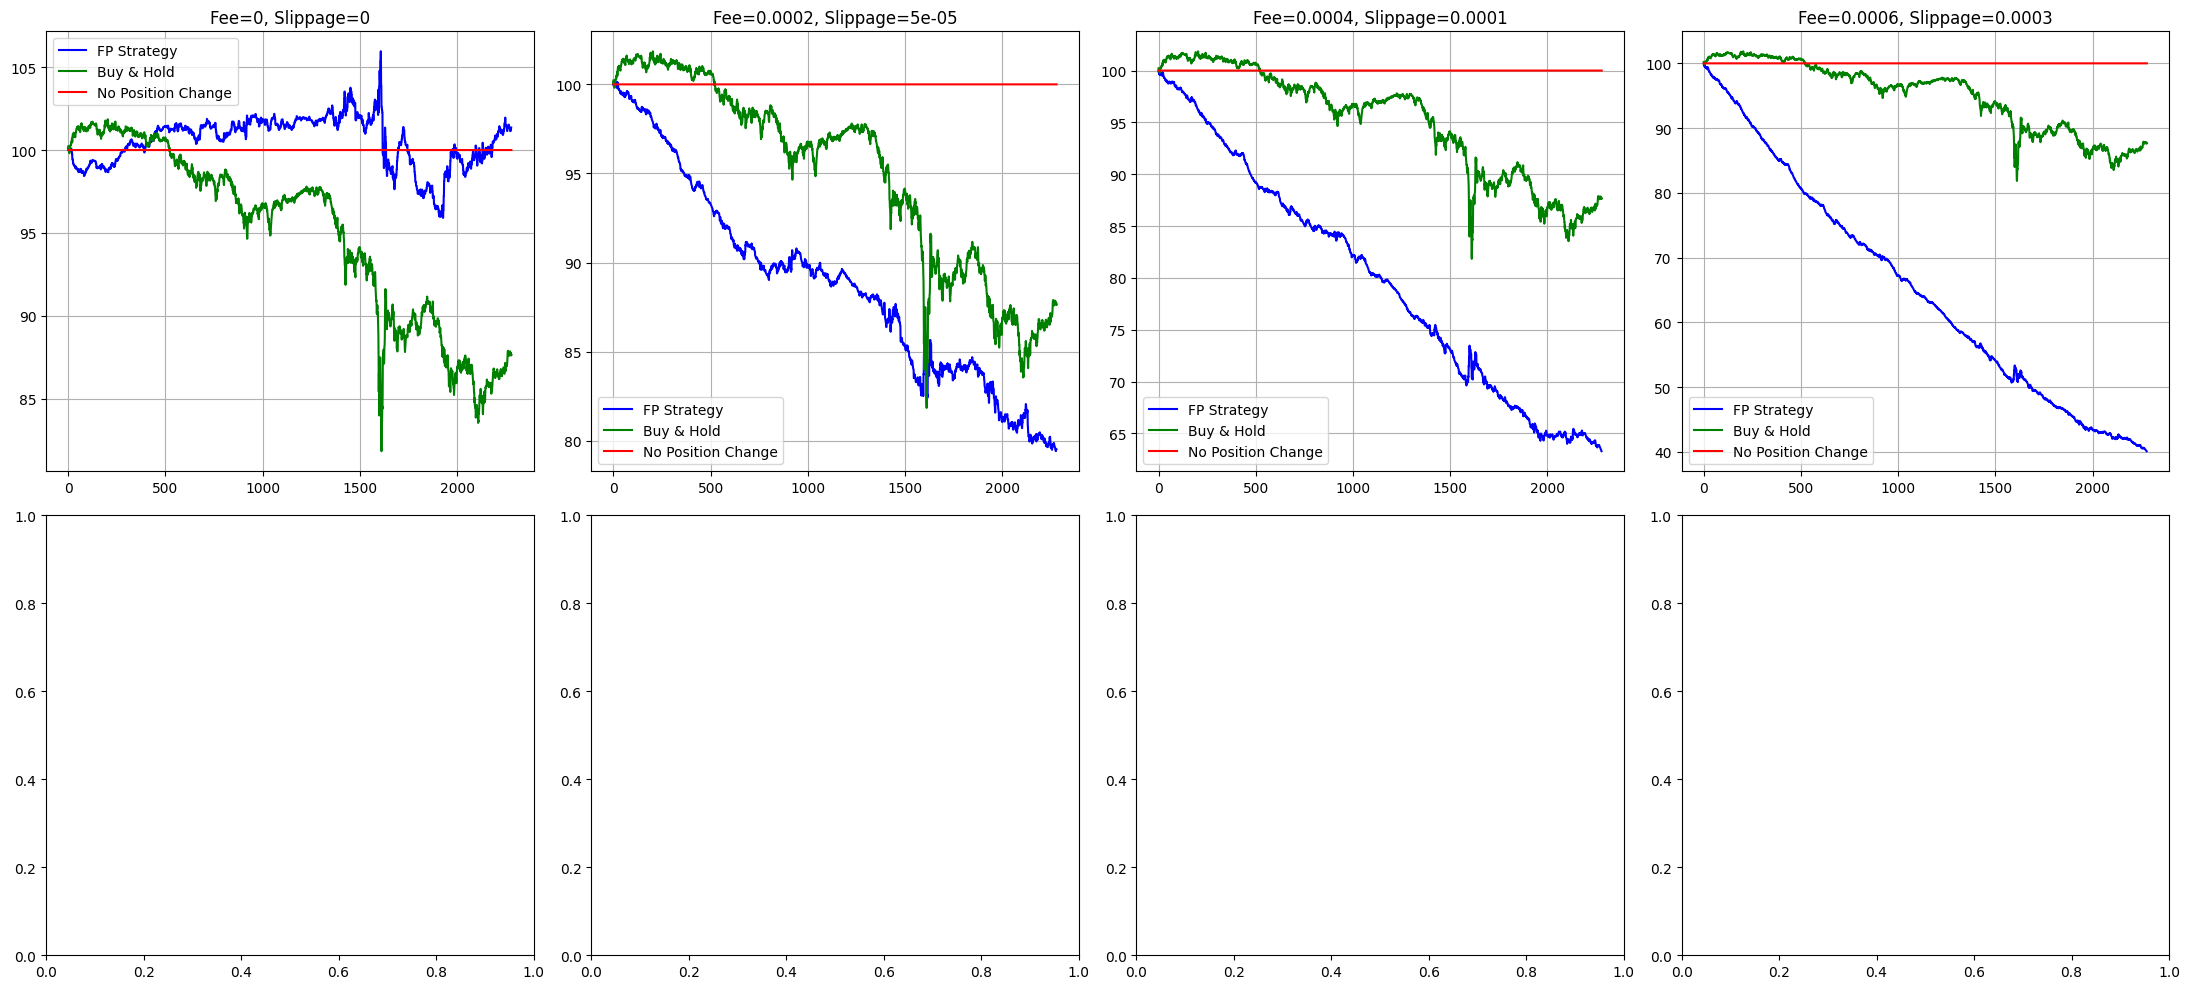


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000           101.36           1.36           87.65                 -12.35    100.0             0.0
0.0002   0.00005            79.53         -20.47           87.65                 -12.35    100.0             0.0
0.0004   0.00010            63.29         -36.71           87.65                 -12.35    100.0             0.0
0.0006   0.00030            40.11         -59.89           87.65                 -12.35    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

df = pd.read_csv("ETH_1min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]
df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['net_queue_slope'] = (df['bids_notional_0'] - df['bids_notional_5']) - (df['asks_notional_0'] - df['asks_notional_5'])
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
df['depth_variance'] = df[bid_cols + ask_cols].std(axis=1)
df['abs_dobi'] = np.abs(df['dobi'])

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

for d in [df_train, df_cv, df_test]:
    d['log_mid'] = np.log(d['midpoint'])
    d['returns'] = d['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.where(signal > threshold, 1, np.where(signal < -threshold, -1, 0))
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, features, timesteps, dt):
    a0, a1, a2, a3, a4, a5, a6 = mu_params
    b0, b1 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        obi_t = features['obi'].iloc[t-1]
        dobi_t = features['dobi'].iloc[t-1]
        depth_t = features['depth'].iloc[t-1]
        slope_t = features['net_queue_slope'].iloc[t-1]
        spread_t = features['spread'].iloc[t-1]
        dv_t = features['depth_variance'].iloc[t-1]
        abs_dobi_t = features['abs_dobi'].iloc[t-1]
        mu = (a0 + a1 * x[t-1] + a2 * obi_t + a3 * dobi_t + a4 * depth_t + a5 * slope_t + a6 * spread_t)
        sigma = np.abs(b0 + b1 * (dv_t + abs_dobi_t))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    features = df_slice[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:7]
        sigma_params = params[7:]
        signal = simulate_fp(mu_params, sigma_params, x_init, features, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0]*7 + [0.005, 0.005], sigma0=0.2, options={'seed':random_seed, 'verb_disp':0})
    return res[0][:7], res[0][7:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(i, i+500) for i in range(0, len(df_train)-500, 500)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, df_cv.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_features = df_test[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_features.iloc[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        continue

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

df = pd.read_csv("ETH_1sec.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]
df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope_bid'] = df['bids_notional_0'] - df['bids_notional_5']
df['queue_slope_ask'] = df['asks_notional_0'] - df['asks_notional_5']
df['net_queue_slope'] = df['queue_slope_bid'] - df['queue_slope_ask']
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

for d in [df_train, df_cv, df_test]:
    d['log_mid'] = np.log(d['midpoint'])
    d['returns'] = d['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.where(signal > threshold, 1, np.where(signal < -threshold, -1, 0))
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, features, timesteps, dt):
    a0, a1, a2, a3, a4, a5, a6, a7 = mu_params
    b0, b1 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        f = features.iloc[t-1]
        mu = a0 + a1 * x[t-1] + a2 * f['obi'] + a3 * f['dobi'] + a4 * f['depth'] + a5 * f['spread'] + a6 * f['queue_slope_bid'] + a7 * f['queue_slope_ask']
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    features = df_slice[['obi', 'dobi', 'depth', 'spread', 'queue_slope_bid', 'queue_slope_ask']]
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:8]
        sigma_params = params[8:]
        signal = simulate_fp(mu_params, sigma_params, x_init, features, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0]*8 + [0.005, 0.005], sigma0=0.2, options={'seed':random_seed, 'verb_disp':0})
    return res[0][:8], res[0][8:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(i, i+200) for i in range(0, len(df_train)-200, 200)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end][['obi', 'dobi', 'depth', 'spread', 'queue_slope_bid', 'queue_slope_ask']], end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, df_cv.iloc[start:end][['obi', 'dobi', 'depth', 'spread', 'queue_slope_bid', 'queue_slope_ask']], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_features = df_test[['obi', 'dobi', 'depth', 'spread', 'queue_slope_bid', 'queue_slope_ask']]
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_features.iloc[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        continue

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


/tmp/ipython-input-4-1011596047.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
